In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F

In [15]:
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
kernalSize1 = 2 # kernal size of the Conv2D layer
poolingWindowSz = 2
numNueronsFCL1 = 128
numNueronsFCL2 = 128
dropOutRatio = 0.2
numOfRows = 90
numOfColumns = 3
numClasses = 6
batchSize = 1

class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        # add random
       
        self.conv1 = nn.Conv2d(numChannels, numFilters, (kernalSize1, kernalSize1))
        self.pool = nn.MaxPool2d((poolingWindowSz, poolingWindowSz))
        self.dropout = nn.Dropout(dropOutRatio)
        self.fc1 = nn.Linear(numFilters * ((numOfRows - kernalSize1 + 1) // poolingWindowSz) * ((numOfColumns - kernalSize1 + 1) // poolingWindowSz), numNueronsFCL1)
        self.fc2 = nn.Linear(numNueronsFCL1, numNueronsFCL2)
        self.fc3 = nn.Linear(numNueronsFCL2, numClasses)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = x.view(-1, numFilters * ((numOfRows - kernalSize1 + 1) // poolingWindowSz) * ((numOfColumns - kernalSize1 + 1) // poolingWindowSz))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
#load python model
model = PyTorchModel()
state_dict = torch.load('model_pytorch.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
testX = np.load('testData.npy')
testY = np.load('groundTruth.npy')
trainX = np.load('trainData.npy')
trainY = np.load('trainLabels.npy')

# Convert the training and testing data to PyTorch tensors
trainX_torch = torch.from_numpy(np.transpose(trainX, (0, 3, 1, 2))).float()
trainY_torch = torch.from_numpy(np.argmax(trainY, axis=1)).long()
testX_torch = torch.from_numpy(np.transpose(testX, (0, 3, 1, 2))).float()
testY_torch = torch.from_numpy(np.argmax(testY, axis=1)).long()

# Create TensorDatasets for training and testing data
train_data = TensorDataset(trainX_torch, trainY_torch)
test_data = TensorDataset(testX_torch, testY_torch)

# Create DataLoaders for training and testing data
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)

In [26]:
#get min max of trainX
min_trainX = np.min(trainX)
max_trainX = np.max(trainX)
print(min_trainX, max_trainX)

-4.322391471376455 4.085751745014715


In [6]:
# In this notebook we will perform Adversarial Patch attack on the model, by treating a training sample as a 2D image (90 X 3) and placing a patch on it.
# We will use the PyTorch framework to implement the attack.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def plot_sample(sample):
    sample = np.transpose(sample.detach().numpy())
    plt.imshow(sample, aspect='auto')
    plt.show()

In [27]:
criterion = nn.CrossEntropyLoss()
def fgsm_attack(model, data, labels, epsilon):
    if epsilon == 0:
        return data
    
    data.requires_grad = True # Set requires_grad attribute of tensor to true because we need to compute the gradient w.r.t to the input data
    outputs = model(data) # Forward pass
    init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
    #if init_pred.item() != labels.item(): # If the initial prediction is wrong, don't bother attacking, just move on
    #    return data
    #loss = F.nll_loss(outputs, labels) # Calculate the loss
    loss = criterion(outputs, labels)
    model.zero_grad() # Zero all existing gradients
    loss.backward() # Calculate gradients of model in backward pass
    data_grad = data.grad.data # Collect datagrad
    sign_data_grad = data_grad.sign() # Call FGSM Attack
    perturbed_data = data + epsilon*sign_data_grad # Create the perturbed image by adjusting each pixel of the input image    
    
    #TODO: Have a look at the range of original data and adjust accordingly
    #perturbed_data = torch.clamp(perturbed_data, 0, 1) # Adding clipping to maintain [0,1] range

    return perturbed_data

In [31]:
def test_fgsm_attack(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []

    for data, target in test_loader: # Loop over all examples in test set
        data, target = data.to(device), target.to(device) # Send the data and label to the device
        outputs = model(data) # Calculate initial prediction
        init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability

        perturbed_data = fgsm_attack(model, data, target, epsilon)  # Call FGSM Attack
        output = model(perturbed_data) # Re-classify the perturbed image

        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      
        if final_pred.item() == target.item():
            correct += 1
        
        # Save some adv examples for visualization later
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [29]:
# Test the attack
epsilon = 0.2
final_acc, adv_examples = test_fgsm_attack(model, device, test_loader, epsilon)

print("Final Accuracy on adversarial examples: ", final_acc)

Epsilon: 0.2	Test Accuracy = 1902 / 4891 = 0.38887753015743204
Final Accuracy on adversarial examples:  0.38887753015743204


In [32]:
# Run attack for different epsilon values
accs = []
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, .45, .5]

for e in epsilons:
    acc, ex = test_fgsm_attack(model, device, test_loader, e)
    accs.append(acc)

Epsilon: 0	Test Accuracy = 4473 / 4891 = 0.9145369045185033
Epsilon: 0	Test Accuracy = 0.9145369045185033
Epsilon: 0.05	Test Accuracy = 3797 / 4891 = 0.7763238601512983
Epsilon: 0.05	Test Accuracy = 0.7763238601512983
Epsilon: 0.1	Test Accuracy = 2999 / 4891 = 0.6131670415048047
Epsilon: 0.1	Test Accuracy = 0.6131670415048047
Epsilon: 0.15	Test Accuracy = 2344 / 4891 = 0.4792475976282969
Epsilon: 0.15	Test Accuracy = 0.4792475976282969
Epsilon: 0.2	Test Accuracy = 1935 / 4891 = 0.39562461664281334
Epsilon: 0.2	Test Accuracy = 0.39562461664281334
Epsilon: 0.25	Test Accuracy = 1614 / 4891 = 0.3299938662850133
Epsilon: 0.25	Test Accuracy = 0.3299938662850133
Epsilon: 0.3	Test Accuracy = 1403 / 4891 = 0.2868534042118176
Epsilon: 0.3	Test Accuracy = 0.2868534042118176
Epsilon: 0.35	Test Accuracy = 1243 / 4891 = 0.25414025761602943
Epsilon: 0.35	Test Accuracy = 0.25414025761602943
Epsilon: 0.4	Test Accuracy = 1101 / 4891 = 0.22510734001226743
Epsilon: 0.4	Test Accuracy = 0.22510734001226743


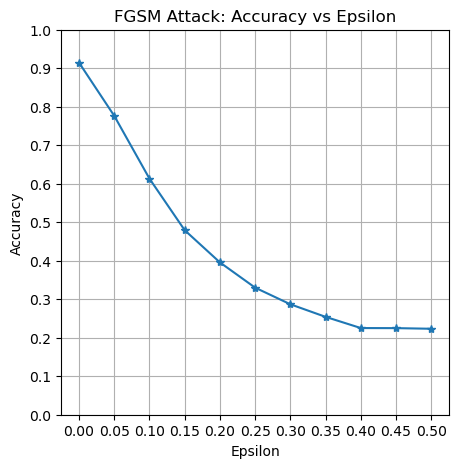

In [36]:
#TODO: plot accuracy vs. epsilon

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(epsilons, accs, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("FGSM Attack: Test Accuracy vs Epsilon")
plt.grid()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
#TODO: get data before normalisation

In [ ]:
#TODO: plot some adversarial examples vs. original examples